In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pandas.tools.rplot as rplot
import copy
import numpy as np
import matplotlib
import operator
from matplotlib.artist import setp

%matplotlib inline
pd.options.display.mpl_style = 'default'
pd.options.display.max_rows = 30
plt.set_cmap('Paired')
matplotlib.style.use('ggplot')


In [2]:
df_raw = pd.DataFrame.from_csv("omit/ai2_data_with_pgroups_raw.csv")
df_groups_raw = pd.DataFrame.from_csv("omit/pgroups_raw.csv")

df_filter_a = pd.DataFrame.from_csv("omit/ai2_data_with_pgroups_FilterA.csv")
df_groups_filter_a = pd.DataFrame.from_csv("omit/pgroups_FilterA.csv")

blocks = [name for name in df_raw.columns if name[:2]=="b_"] #111 total

In [3]:
df = pd.DataFrame.from_csv("omit/ai2_data.csv")
df = df.fillna(0) #replacing NaN w/ 0

In [4]:
#For has_multiplier()
loop_blocks = ['b_controls_forRange', 'b_controls_while', 'b_controls_forEach']
list_blocks = [ 'b_lists_create_with', 'b_lists_from_csv_table', 'b_lists_from_csv_row']
proc = 'has_procedure'
loop = 'has_loop'
li = 'has_list'
mult_cols = [proc, loop, li]

#Functions for data manipulation

#Given dataframe, return dataframe w/ new column col_name that sums given features
def add_agg_column(df_inp, col_name, features):
    df_tmp = df_inp.copy()
    df_tmp[col_name] = 0 #defining column
    for ind, row in df_tmp[features].iterrows(): #iterating through rows
        result = int(row.values.sum()) #TODO: Debug here. was having trouble with NaN so removed cast to Int. 
        df_tmp.loc[ind, col_name] = result
    return df_tmp

# given path to 2 column csv, return dictionary where key is first col
# key_as_first: true if first col is key (false is 2nd is)
# 1st col: component/block name
# 2nd col: component/block category
def csv_to_dict(path, key_as_first=True):
    reader = csv.reader(open(path, 'r'))
    d = {}
    for row in reader:
        if key_as_first:
            k, v = row
            d[k] = v
        else:
            v, k = row
            if k in d:
                d[k]+=[v] #add to list
            else:
                d[k]=[v]
    return d

def add_groups_col(df_inp):
    col_name = 'palette_groups'
    col_name_counter = 'num_palette_groups'
    col_basic = 'agg_basic'
    agg_groups = ['agg_lego', 'agg_media', 'agg_storage', 
                'agg_connect', 'agg_social', 'agg_sensor', 'agg_drawing']
    df_tmp = df_inp.copy()
    
    df_tmp[col_name] = "" #defining column
    df_tmp[col_name_counter] = 0 #defining column
    
#     index = 0;
    for ind, row in df_tmp.iterrows(): #iterating through rows
        groups = ""
        num_counter = 0
        for grp in agg_groups:
            if row[grp]>0:
                groups+=grp[4:]+","
        #lego in own group
        if 'lego' in groups:
            df_tmp.loc[ind, col_name] = 'lego'
            df_tmp.loc[ind, col_name_counter] = 1
        elif len(groups)>0:    
            df_tmp.loc[ind, col_name] = groups[:-1] #removing trailing comma
            df_tmp.loc[ind, col_name_counter] = len(groups[:-1].split(","))
        else:
            df_tmp.loc[ind, col_name]= col_basic[4:]
            df_tmp.loc[ind, col_name_counter] = 1
#         index = index+1
    return df_tmp

#Given a dataframe, return dataframe w/ 3 new columns: has_procedures, has_loop, has_list
def has_multipliers(df_inp):
    df_tmp = df_inp.copy()
    
    #defining column
    for col in mult_cols:
        df[col] = 0
    
#     index=0
    for ind, row, in df_tmp.iterrows():
        #existence of procedure, called more than once, called more often than defined (proc. used properly)
        num_procs_def = row['b_procedures_defnoreturn'] + row['b_procedures_defreturn']
        num_procs_call = row['b_procedures_callnoreturn'] + row['b_procedures_defnoreturn']
        if num_procs_def>0 and num_procs_call>1 and num_procs_call>num_procs_def:
            df_tmp.loc[ind, proc] = 1
            
        #existence of any loop block
        for lp in loop_blocks:
            if row[lp]>0:
                df_tmp.loc[ind, loop] = 1
                break
        
        for lis in list_blocks:
            if row[lis]>0:
                df_tmp.loc[ind, li] = 1
                break
#         index = index+1
    return df_tmp

#Given dataframe, add column that lists(string really) blocks in project
def add_blocks_list(df_inp):
    #get all columns w/ blocks
    blocks = [name for name in df_inp.columns if name[:2]=="b_"]
    
    col_name = 'blocks'
    df_tmp = df_inp.copy()
    
    df[col_name] = "" #defining new column
    
    for ind, row in df_tmp.iterrows(): #iterating through rows
        blocks_str = ""
        for blk_col in blocks:
            if row[blk_col]>0:
                blocks_str+=blk_col[2:]+", " #removing "b_" at beginning
        df_tmp.loc[ind, col_name] = blocks_str[:-2] #removing trailing ", "
    return df_tmp   

#Given dataframe, add column that lists(string really) unique components
def add_components_list(df_inp):
    #get all columns w/ blocks
    components = [name for name in df_inp.columns if name[:2]=="c_"]
    
    col_name = 'components'
    df_tmp = df_inp.copy()
    
    df[col_name] = "" #defining new column
    
    for ind, row in df_tmp.iterrows(): #iterating through rows
        cmp_str = ""
        for cmp_col in components:
            if row[cmp_col]>0:
                cmp_str+=cmp_col[2:]+", " #removing "c_" at beginning
        df_tmp.loc[ind, col_name] = cmp_str[:-2] #removing trailing ", "
    return df_tmp
    

# df_with_pgroups: big df with agg cols, num palette columns, palette columns
# df_count: simple df (7x2) where cols are 'count' and 'group name'
# df_groups: df used for plotting w/ each pgroup as col and each row as num_blocks_unique for project in group
# path: where to put files
# suffix: string to put at end of file names
def save_agg_dfs(df_with_pgroups, df_count, df_groups, path, suffix):
    df_with_pgroups.to_csv(path+"/ai2_data_with_pgroups_"+suffix+".csv")
    df_count.to_csv(path+"/pgroup_count_"+suffix+".csv")
    df_groups.to_csv(path+"/pgroups_"+suffix+".csv")
    

In [5]:
#Random cell for debugging helper functions above

In [6]:
# len(df_test)

In [7]:
# Testing has_multipliers()
# df_test = has_multipliers(df_work)
# df_test[loop_blocks+list_blocks+['has_loop', 'has_list']][df_test.has_loop>0]

In [8]:
#dictionaries that map components to groups
cat_to_comps = csv_to_dict("component_category.csv", False)
cat_to_comps.pop('layout')

#removing too common components (to reduce overlap of groups)
cat_to_comps['sensor'].remove('c_Clock') #removing b/c very common component
cat_to_comps['media'].remove('c_Sound')

# cat_to_comps['lego']

# cat_to_comps

In [9]:
#adding aggregate columns for palette groups
#Takes ~ 1-2 min to run
agg_cols = []

#raw data
for key in cat_to_comps:
    agg_cols.append('agg_'+key)
    df = add_agg_column(df, 'agg_'+key, cat_to_comps[key])

#adding 'num_palette_groups', 'palette_groups' columns
df = add_groups_col(df)

#adding multiplier counts
df = has_multipliers(df)

#add column that lists all blocks (in string)
df = add_blocks_list(df)

#add column that lists all components (in string)
df = add_components_list(df)

In [10]:
#removing "certainly nonfunctional projects"
df_work = df[df.num_blocks>=2][df.num_components>0] #removing "certainly non-functional"
# df_work[['num_blocks','num_components']].describe()

/Users/bxie/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1808: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [11]:
#current dataframe for analysis (update this to update ref to dataframes below)
df_this = df_work

In [12]:
# df_this[df_this.b_procedures_defreturn>0].count()+ df_this[df_this.b_procedures_defnoreturn>0].count()
# df_this[df_this.has_procedure==1].count()


In [98]:
#Seeing what group tutorials fit into

# Key:Tutorial name, value: search terms
tutorials = {"hello_purr":"purr",
             "talk_to_me":"talk",
             "ball_bounce":"bounce",
             "digital_doodle:" : "doodle",
             "magic_8_ball": "magic",
             "paintpot" : "paint",
             "i_have_dream" : "dream",
             "pic_call": "piccall|pic_call", #tutorial doesn't work in AI2
             'get_gold': "gold",
             "video_wall": "videowall|video_wall",
             "stockquotes": "stockquotes|stock_quotes",
             "mini_golf" : "minigolf|mini_golf",
             "space_invaders" : "spaceinvader|space_invader",
             "no_text":"notext|driving",
             "mole_mash": "mash",
             "sharing": "sharing",
             "colored_dots": "colored",
             "pizza_party": "pizza",
             "nfc_cups": "cup",
             "where_car": "where",
             "map_it": "mapit|map_it",
             "loc_sensor":"location",
             "spikes":"ohmyspikes|oh_my_spikes"}

tutorials_count = {}
total_tutorials = 0
total_working_tutorials = 0

for entry in tutorials:
    search_term = tutorials[entry]
    count_work = len(df_this[df_this.project_name.str.contains(search_term)])
    count_all = len(df_raw[df_raw.project_name.str.contains(search_term)])
    tutorials_count[entry] = count_work, count_all
    
    total_tutorials += count_all
    total_working_tutorials += count_work

print total_tutorials
print total_working_tutorials
print len(tutorials)

################
search_criteria = tutorials['hello_purr']

df_result = df_this[df_this.project_name.str.contains(search_criteria)][['project_name', 'palette_groups', 'components', 'num_components']]
groups = df_result.groupby(df_result.palette_groups).groups

#key: group, value: frac of tutorials in that group
freq = {}
for group in groups:
    count = df_result[df_result.palette_groups==group][['palette_groups']].count()
    freq[group] = count/len(df_result)
#     print group + ": " + str(count) 

df_result

1031
917
23


,project_name,palette_groups,components,num_components
88,hellopurr,basic,"Button, Label, Sound",3
126,hellopurr,basic,"Button, Label, Sound",3
363,the3c_16_hello_purr,basic,"Button, Sound, Image",3
368,hellopurr,basic,"Button, Label, Sound",3
702,hellopurrcompletedversiom,basic,"Button, Label, Sound",3
739,hellopurr,basic,"Button, Sound",2
740,hellopurr,basic,"Button, Sound",2
902,hellopurr,media,"Button, Label, Sound, Player",4
1037,hellopurr,basic,"Button, Sound",2
1128,hellopurr3,drawing,"Canvas, HorizontalArrangement, Sound",7


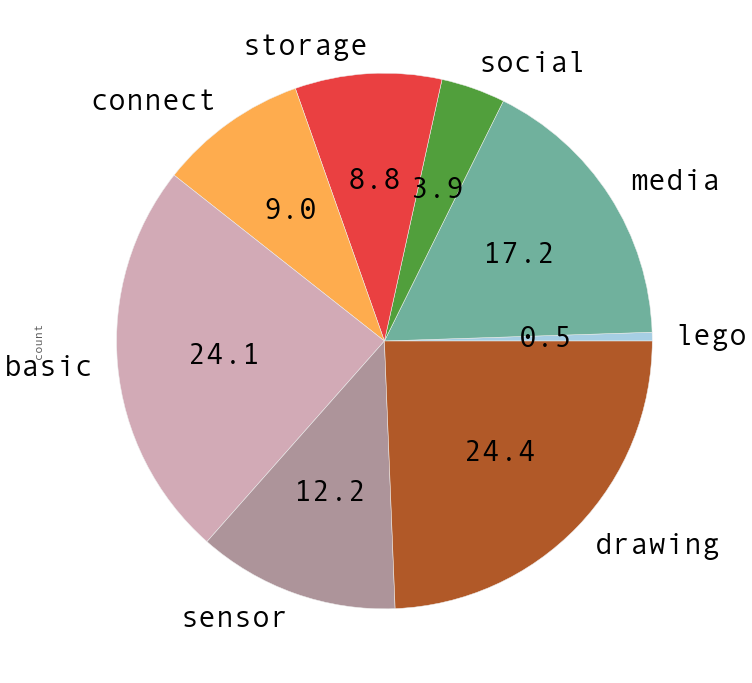

In [110]:
#Number of projects that fit into each palette group

#(ignoring all overlap, so some projects double counted)
data = {'group':cat_to_comps.keys(),
       'count': []} #supposed to be named 'count' or something but that shows up on pie chart

num_unique = {}

for val in data['group']:
    count = df_this[df_this.palette_groups.str.contains(val)]['palette_groups'].count()
    data['count'].append(count)

# data 
df_count = pd.DataFrame(data=data['count'], index=data['group'], columns=['count'])

df_count_t = df_count.transpose()
# print df_count_t.values.sum()
# df_count_t.plot(kind='barh', stacked=True, figsize=(12,4))
plot = df_count.plot(kind='pie', subplots=True, figsize=(12,12), legend=False, fontsize=30, colormap='Paired', autopct='%.1f')


In [15]:
#separating df by group (overlap exists)

agg_cols = ['agg_basic', 'agg_lego', 'agg_media', 'agg_storage', 'agg_connect', 'agg_social', 'agg_sensor', 'agg_drawing']

df_basic = df_this[df_this.agg_lego==0][df_this.agg_media==0][df_this.agg_storage==0][df_this.agg_connect==0][df_this.agg_social==0][df_this.agg_sensor==0][df_this.agg_drawing==0].reset_index()
df_lego = df_this[df_this.agg_lego>0].reset_index()
df_media = df_this[df_this.agg_media>0].reset_index()
df_storage = df_this[df_this.agg_storage>0].reset_index()
df_connect = df_this[df_this.agg_connect>0].reset_index()
df_social = df_this[df_this.agg_social>0].reset_index()
df_sensor = df_this[df_this.agg_sensor>0].reset_index()
df_draw = df_this[df_this.agg_drawing>0].reset_index()
df_all = df_this.reset_index()

In [16]:
df_count.sum()

count    5369
dtype: int64

In [17]:
# groups = [df_all, df_basic, df_lego, df_media, df_storage, df_connect, df_social, df_sensor, df_draw]

# group_names = ['all', 'basic', 'lego', 'media', 'storage', 'connect', 'social', 'sensor', 'draw']

agg_groups = {'all': df_all,
             'basic': df_basic,
             'lego': df_lego,
             'media': df_media,
             'storage': df_storage,
             'connect': df_connect,
             'social': df_social,
             'sensor': df_sensor,
             'drawing': df_draw,
             }
 
#new dataframe where each group is column (rows don't correspond to anything really)
df_groups = pd.DataFrame()
df_groups_f = pd.DataFrame()
for name, agg_df in agg_groups.iteritems():
    print name
    col = agg_df['num_blocks_unique']
    df_groups.insert(len(df_groups.columns), name, col)
    
    #Sanity check (had this issue, resolved by calling reset_index() for df_all)
    if len(col)!=len(df_groups[name].dropna()):
        print 'WARNING: Not all projects being transferred to df_groups'

# print 'all'
# df_groups.insert(len(df_groups.columns), 'all', agg_all['num_blocks_unique']                 
# df_groups.to_csv("temp.csv")
print df_groups.head(3)    

all
sensor
connect
basic
media
lego
storage
drawing
social
   all  sensor  connect  basic  media  lego  storage  drawing  social
0   10      11       18      8      5     5       19       10      12
1    3      18       12      3     18     5        3        3       5
2    8       3        5      6      4     3       17       11      22


In [18]:
# df_storage[df_storage.num_blocks_unique==47]
# df_storage['num_blocks_unique'].max()
df_groups.storage.max()

56.0

In [19]:
# save_agg_dfs(df, df_count, df_groups, "omit", "SOMETHING")

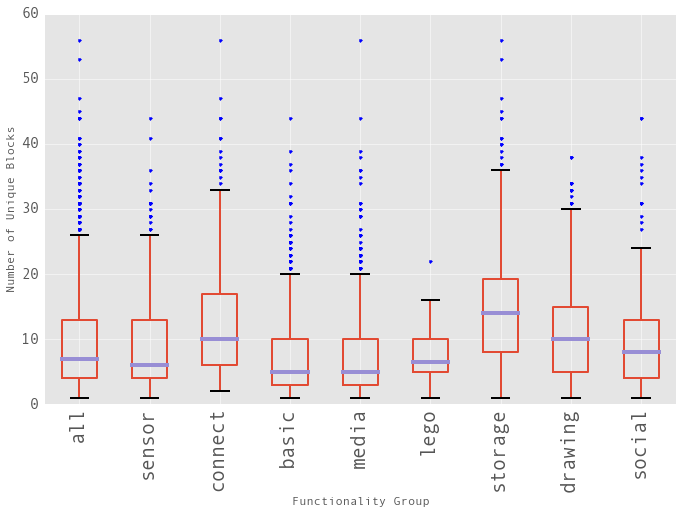

In [99]:
# df_groups.plot(kind='box', figsize=(11.326,7), sym='b.', rot= 90, fontsize=20)

fig = plt.figure(figsize=(11.326,7))
ax, bp = df_groups.boxplot(return_type='both')
plt.set_cmap('Paired')
plt.setp(bp['boxes'], lw=2)
plt.setp(bp['whiskers'], lw=2, linestyle='solid')
plt.setp(bp['medians'], lw=4)
plt.setp(bp['caps'], lw=2)
plt.setp(bp['fliers'], marker='.')
plt.set_cmap('Paired')
ax.set_xlabel('Functionality Group')
ax.set_ylabel('Number of Unique Blocks')
ax.set_xticklabels(df_groups.columns, rotation=90, fontsize=20)
ax.set_yticklabels(range(0,61,10), fontsize=15)

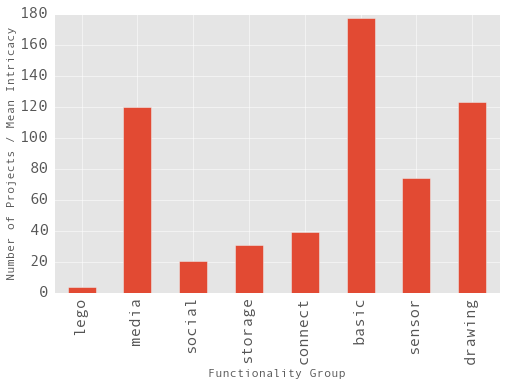

In [116]:
#relationship between intricacy and # of projects by group

df_test = df_count.copy()
s = df_test.sum()
s.name = 'all'
df_test = df_test.append(s)
df_test['avg'] = df_groups.mean()
df_test['med'] = df_groups.median()
df_test = df_test.drop('all')

# df_test
# df_groups[~['all']]
df_ratio = df_test['count'] / df_test['avg']
plot = df_ratio.plot(kind='bar', figsize=(8,5), fontsize=16,)
plot.set_ylabel('Number of Projects / Mean Intricacy')
plot.set_xlabel('Functionality Group')


# df_ratio.plot(kind='bar', x='c', y='d', color='DarkGreen');

# df_ratio_med = df_test['count'] / df_test['med']
# df_ratio_med.plot(kind='bar')

# df_ratio_2 = df_test['avg'] / df_test['count']
# df_ratio_2.plot(kind='bar')


#LEARNABILITY

In [100]:
#ratio to measure learnability, capability
tmp = pd.DataFrame(data=df_groups.describe())
low = tmp.loc['25%',:]- tmp.loc['min',:]
iqr = tmp.loc['75%',:] - tmp.loc['25%',:]

ratio = 2.5*iqr / low #normalize somehow to get this to work

#results not very definitive of anything (lego and storage next to each other...yikes)
# ratio.plot(kind='bar')

In [23]:
#Pearson Mode Skewness
skew = (df_groups.mean() - df_groups.median()) / df_groups.std()
skew.sort(ascending=True)
# skew.plot(kind='bar')
print skew

#Pearson Mode Skewness, Alternative
# 3*(df_groups.mean() - df_groups.median()) / df_groups.std()


drawing    0.101533
storage    0.149915
social     0.246112
lego       0.279313
connect    0.280850
all        0.294018
basic      0.403098
sensor     0.413545
media      0.418555
dtype: float64


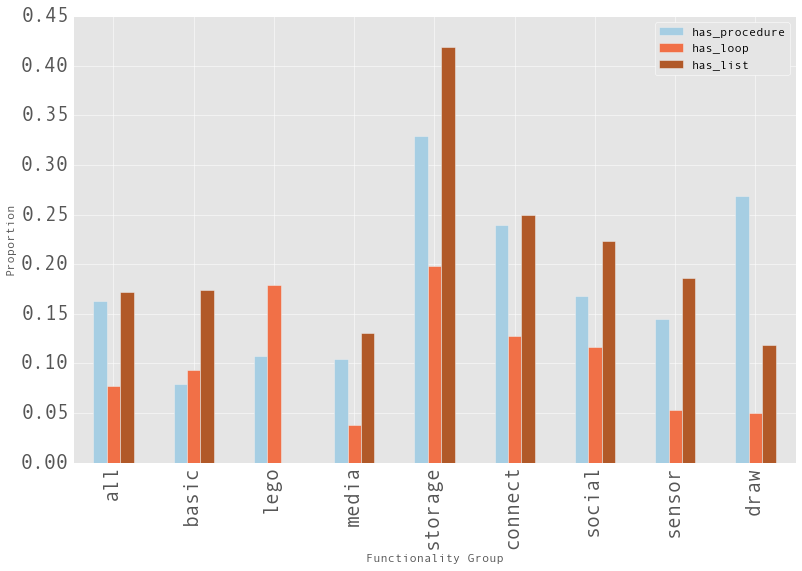

In [101]:
groups = [df_all, df_basic, df_lego, df_media, df_storage, df_connect, df_social, df_sensor, df_draw]

group_names = ['all', 'basic', 'lego', 'media', 'storage', 'connect', 'social', 'sensor', 'draw']

#new dataframe where each group is column (rows don't correspond to anything really)
df_mult = pd.DataFrame(columns = mult_cols, index=group_names)

for i in range(len(groups)):
    group_name = group_names[i] #basic, lego
    df_temp = groups[i] #df of specific group
    for j in range(len(mult_cols)): #0-2
        mult_name = mult_cols[j]
        frac = float(df_temp[mult_name].sum()) / float(len(df_temp)) #frac of projects that has multiplier
        df_mult.loc[group_names[i], mult_name] = frac

        
cmap = 'Paired'
plot = df_mult.plot(kind='bar', figsize=(12.944,8), fontsize=20, colormap=cmap)
plot.set_xlabel('Functionality Group')
plot.set_ylabel('Proportion')
        
#looping through colormaps to find one that looks good in gray scale
# qual=['Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3']        
# for val in qual:
#     df_mult.plot(kind='bar', figsize=(12.944,8), fontsize=20, colormap=val, title=val)

Looking at Outlier Projects

In [25]:
#figuring out project w/ most num unique blocks
#it's a password keeper!!! "v2_67"
# max_unique = df_this['num_blocks_unique'].max()

# df_max = df_this[df_this['num_blocks_unique']==max_unique]
# df_max[['palette_groups']+agg_cols]
#69 total
#getting all outlier projects
df_outlier = df_this[np.abs(df_this.num_blocks_unique-df_this.num_blocks_unique.mean())>=(3*df_this.num_blocks_unique.std())]
# df_outlier[['project_name', 'num_components', 'num_blocks', 'num_blocks_unique', 'palette_groups', 'num_palette_groups' ]]
df_outlier.groupby(df_outlier.palette_groups)

In [26]:
#Determmining which components appear most in multiple groups

#list of all columns refering to blocks or components
# blocks = [name for name in df.columns if name[:2]=="b_"] #111 total
# components = [name for name in df.columns if name[:2]=="c_"] #57 total

# count = df[df.num_palette_groups>1][components].apply(lambda column: (column!=0).sum())
# count.sort(ascending=False)
# count

In [27]:
iqr  = 0.6745 #fraction of std deviation = 1 quartile
# (df_groups.median()+(2.698+0.7*df_groups.std()) / (0.6745*df_groups.std())
# df_groups.quantile(q=0.99)
# /df_groups.quantile(q=0.25)

In [28]:
# df[['num_palette_groups']].hist()
# df[df.num_palette_groups>1]['num_palette_groups'].hist()

4121
basic                     1294
drawing                    916
media                      372
connect                    231
media,sensor               182
storage                    161
media,drawing              133
sensor                     126
sensor,drawing             122
social                      58
storage,connect,sensor      51
storage,connect             41
storage,drawing             38
media,sensor,drawing        34
media,connect               29
dtype: int64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x10dfed710>], dtype=object)

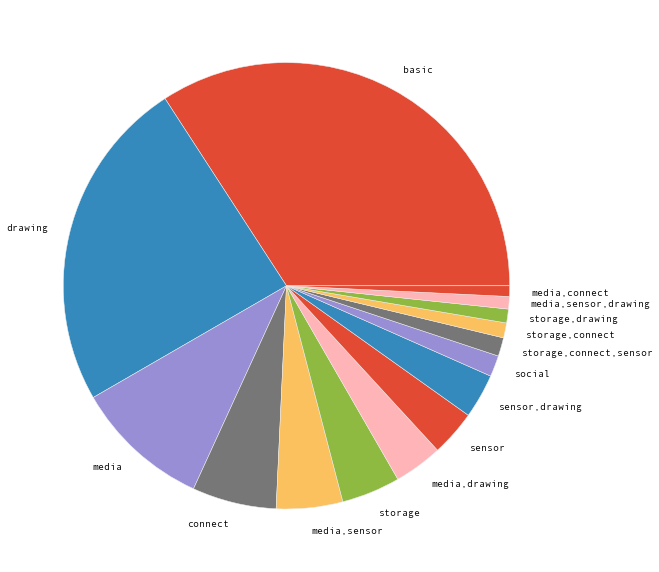

In [29]:
count = df_this['palette_groups'].value_counts()
print count.sum()
print count.head(15)
count.head(15).plot(kind='pie', subplots=True, figsize=(10,10))

In [30]:
#% of each group
NUM_PROJS = len(df_this)
# for key in count.keys:
#     count[keys] = count[keys] / NUM_PROJS
sum=0
i = 0;
for key, val in count.iteritems():
    if i<15:
        sum+=val
    i=i+1
    print key + "\t" + str(val) + "\t" + str(float(val)/NUM_PROJS)
#     "%.2f" % a
print i
print sum
print float(sum)/NUM_PROJS

basic	1294	0.314001455957
drawing	916	0.222276146566
media	372	0.090269352099
connect	231	0.0560543557389
media,sensor	182	0.0441640378549
storage	161	0.0390681873332
media,drawing	133	0.0322737199709
sensor	126	0.0305751031303
sensor,drawing	122	0.0296044649357
social	58	0.0140742538219
storage,connect,sensor	51	0.0123756369813
storage,connect	41	0.00994904149478
storage,drawing	38	0.00922106284882
media,sensor,drawing	34	0.00825042465421
media,connect	29	0.00703712691094
lego	28	0.00679446736229
media,storage	26	0.00630914826498
storage,sensor	22	0.00533851007037
storage,social	21	0.00509585052172
connect,sensor	21	0.00509585052172
media,social	20	0.00485319097306
media,storage,connect	17	0.00412521232711
media,storage,drawing	16	0.00388255277845
media,storage,social	12	0.00291191458384
connect,social	12	0.00291191458384
social,sensor	11	0.00266925503519
media,storage,social,sensor	11	0.00266925503519
media,connect,social	9	0.00218393593788
media,connect,sensor	8	0.00194127638923
med